# Imports


In [11]:
%pip install --upgrade torch torchvision --index-url https://download.pytorch.org/whl/cu118

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.


In [12]:
import re
import spacy
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tqdm import tqdm
import nltk
import contractions

nltk.download("stopwords")


class TextPreprocessingPipeline:
    def __init__(self, config):
        """
        Инициализация класса для предобработки текста.

        Parameters:
        -----------
        config : dict
            Словарь с ключами — названиями методов, значениями — True/False, указывающими, применять ли метод.
        """
        self.config = config
        self.stop_words = set(stopwords.words("english"))
        self.stemmer = PorterStemmer()

        try:
            self.nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
        except OSError:
            print("Модель 'en_core_web_sm' не найдена. Устанавливаю...")
            spacy.cli.download("en_core_web_sm")
            self.nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

    def preprocess(self, text):
        """
        Выполняет предобработку текста в зависимости от конфигурации.

        Parameters:
        -----------
        text : str
            Исходный текст для обработки.

        Returns:
        --------
        str
            Обработанный текст.
        """
        if self.config.get("remove_html_tags", False):
            text = re.sub(r"<[^>]*>", " ", text)

        if self.config.get("remove_emails", False):
            text = re.sub(r"\S*@\S*\s+", " ", text)

        if self.config.get("remove_urls", False):
            text = re.sub(r"https?://\S+|www\.\S+", " ", text)

        if self.config.get("lowercase", False):
            text = text.lower()

        if self.config.get("expand_contractions", False):
            text = self.expand_contractions(text)

        if self.config.get("remove_stopwords", False):
            text = self.remove_stopwords(text)

        if self.config.get("remove_punctuation", False):
            text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)

        if self.config.get("lemmatize", False):
            text = self.lemmatize(text)

        if self.config.get("stem_words", False):
            text = self.stem_words(text)

        if self.config.get("remove_digits", False):
            text = re.sub(r"\b\d+\b", "", text)

        if self.config.get("remove_extra_spaces", False):
            text = re.sub(r"\s+", " ", text).strip()

        return text

    def expand_contractions(self, text):
        expanded_words = [contractions.fix(word) for word in text.split()]
        return " ".join(expanded_words)

    def remove_stopwords(self, text):
        words = text.split()
        words = [word for word in words if word not in self.stop_words]
        return " ".join(words)

    def lemmatize(self, text):
        doc = self.nlp(text)
        lemmatized = " ".join([token.lemma_ for token in doc if len(token.lemma_) > 1])
        return lemmatized

    def stem_words(self, text):
        words = text.split()
        stemmed_words = [self.stemmer.stem(word) for word in words]
        return " ".join(stemmed_words)

    def preprocess_column(self, df, column_name):
        """
        Применяет предобработку к указанному столбцу текста в DataFrame.

        Parameters:
        -----------
        df : pd.DataFrame
            DataFrame с текстовыми данными.
        column_name : str
            Название столбца для обработки.

        Returns:
        --------
        pd.DataFrame
            DataFrame с добавленным столбцом обработанного текста.
        """
        tqdm.pandas()
        df[f"{column_name}_processed"] = df[column_name].progress_apply(self.preprocess)
        return df


[nltk_data] Downloading package stopwords to /home/nord/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    balanced_accuracy_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import display


class ModelEvaluator:
    def __init__(self):
        """
        Инициализация класса для оценки модели.
        """
        pass

    def display_results(
        self,
        model,
        X_test,
        y_test,
        vectorizer=None,
        average="weighted",
        show_help=False,
    ):
        """
        Метод для отображения предсказаний модели на тестовом наборе данных и вычисления метрик.

        Parameters:
        -----------
        model : object
            Обученная модель для предсказаний.
        X_test : np.array, pd.DataFrame или pd.Series
            Тестовые данные для предсказаний. Если используется BoW или TF-IDF, то это тексты, которые преобразуются
            с помощью vectorizer. Если используются эмбеддинги, то это уже готовые векторные представления.
        y_test : list или np.array
            Истинные метки для тестовых данных.
        vectorizer : object, optional
            Vectorizer (например, CountVectorizer или TfidfVectorizer), который был использован для преобразования
            текста в вектора. Если переданы уже эмбеддинги, то можно не указывать.
        average : str
            Средний параметр для расчёта метрик (по умолчанию 'weighted' для многоклассовых задач).
        show_help : bool
            Флаг для отображения блока с описанием метрик (по умолчанию False).

        Returns:
        --------
        pd.DataFrame
            Таблица с метриками.
        """
        if vectorizer is not None:
            X_test = vectorizer.transform(X_test)

        if y_test.dtype == "object":
            y_test = np.where(y_test == "spam", 1, 0)

        predictions = model.predict(X_test)

        if isinstance(predictions[0], str):
            predictions = np.where(predictions == "spam", 1, 0)

        pred_probabilities = (
            model.predict_proba(X_test)[:, 1]
            if hasattr(model, "predict_proba")
            else None
        )

        accuracy = accuracy_score(y_test, predictions)
        balanced_acc = balanced_accuracy_score(y_test, predictions)
        precision = precision_score(y_test, predictions, average=average)
        recall = recall_score(y_test, predictions, average=average)
        f1 = f1_score(y_test, predictions, average=average)
        roc_auc = (
            roc_auc_score(y_test, pred_probabilities)
            if pred_probabilities is not None
            else None
        )

        metrics_df = pd.DataFrame(
            {
                "Metric": [
                    "Accuracy",
                    "Balanced Accuracy",
                    "Precision",
                    "Recall",
                    "F1 Score",
                    "ROC-AUC",
                ],
                "Value": [accuracy, balanced_acc, precision, recall, f1, roc_auc],
            }
        )
        display(metrics_df)

        cm = confusion_matrix(y_test, predictions)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title("Confusion Matrix")
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
        plt.show()

        if pred_probabilities is not None:
            fpr, tpr, _ = roc_curve(y_test, pred_probabilities)
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
            plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve")
            plt.legend()
            plt.show()

        if show_help:
            self.display_help()

        return metrics_df

    def display_help(self):
        """
        Метод для отображения описания метрик, которые выводятся в методе display_results.
        """
        help_text = """
        Описание метрик:

        1. **Accuracy** — точность. Соотношение правильно предсказанных наблюдений к общему числу наблюдений. 
           Пример: 80% — это значит, что 80% наблюдений были предсказаны правильно.

        2. **Balanced Accuracy** — сбалансированная точность. Среднее значение между точностью по каждому классу, особенно полезна при несбалансированных классах.

        3. **Precision** — точность. Соотношение правильно предсказанных положительных наблюдений ко всем предсказанным положительным наблюдениям. 
           Пример: Если модель предсказала 100 положительных случаев, но только 80 из них были правильными, точность составит 80%.

        4. **Recall** — полнота. Соотношение правильно предсказанных положительных наблюдений ко всем реальным положительным наблюдениям. 
           Пример: Если есть 100 положительных случаев и модель нашла 80 из них, то полнота будет 80%.

        5. **F1 Score** — гармоническое среднее между точностью и полнотой. Это мера, которая помогает найти баланс между точностью и полнотой.

        6. **ROC-AUC** — площадь под ROC-кривой. Мера, показывающая, насколько хорошо модель различает классы. 
           Значение 1.0 означает идеальную модель, значение 0.5 означает, что модель работает не лучше случайного угадывания.

        """
        print(help_text)

    def compare_models(
        self, models, test_data, y_test, show_help=False, average="weighted", n_cols=3
    ):
        """
        Метод для сравнения производительности нескольких моделей по метрикам.

        Parameters:
        -----------
        models : dict
            Словарь, где ключ — название модели (str), а значение — обученная модель.
        test_data : dict
            Словарь, где ключ — название модели (str), а значение — данные для тестирования модели (обработанные BoW, TF-IDF или эмбеддинги).
        y_test : list или np.array
            Истинные метки для тестовых данных.
        show_help : bool
            Флаг для отображения блока с описанием метрик (по умолчанию False).
        average : str
            Средний параметр для расчёта метрик (по умолчанию 'weighted' для многоклассовых задач).
        n_cols : int
            Количество графиков в строке для отображения метрик (по умолчанию 3).

        Returns:
        --------
        pd.DataFrame
            Таблица с метриками для каждой модели.
        """
        results = {}
        roc_curves = {}

        if y_test.dtype == "object":
            y_test = np.where(y_test == "spam", 1, 0)

        for model_name, model in models.items():
            X_test_transformed = test_data[model_name]

            predictions = model.predict(X_test_transformed)

            if isinstance(predictions[0], str):
                predictions = np.where(predictions == "spam", 1, 0)

            pred_probabilities = (
                model.predict_proba(X_test_transformed)[:, 1]
                if hasattr(model, "predict_proba")
                else None
            )

            accuracy = accuracy_score(y_test, predictions)
            balanced_acc = balanced_accuracy_score(y_test, predictions)
            precision = precision_score(y_test, predictions, average=average)
            recall = recall_score(y_test, predictions, average=average)
            f1 = f1_score(y_test, predictions, average=average)
            roc_auc = (
                roc_auc_score(y_test, pred_probabilities)
                if pred_probabilities is not None
                else None
            )

            results[model_name] = {
                "Accuracy": accuracy,
                "Balanced Accuracy": balanced_acc,
                "Precision": precision,
                "Recall": recall,
                "F1 Score": f1,
                "ROC-AUC": roc_auc,
            }

            if pred_probabilities is not None:
                fpr, tpr, _ = roc_curve(y_test, pred_probabilities)
                roc_curves[model_name] = (fpr, tpr, roc_auc)

        results_df = pd.DataFrame(results).transpose()
        display(results_df)

        if show_help:
            self.display_help()

        metrics = [
            "Accuracy",
            "Balanced Accuracy",
            "Precision",
            "Recall",
            "F1 Score",
            "ROC-AUC",
        ]

        num_metrics = len(metrics)
        n_rows = (num_metrics + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
        axes = axes.flatten()

        for i, metric in enumerate(metrics):
            values = [
                results[model_name][metric]
                for model_name in results
                if results[model_name][metric] is not None
            ]
            axes[i].bar(results.keys(), values)
            axes[i].set_title(f"Сравнение моделей по {metric}")
            axes[i].set_ylabel(metric)

        for j in range(i + 1, n_rows * n_cols):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()

        if roc_curves:
            plt.figure(figsize=(8, 6))
            for model_name, (fpr, tpr, roc_auc) in roc_curves.items():
                plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.4f})")
            plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curves of All Models")
            plt.legend()
            plt.show()


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display


class EDAEmbedding:
    """
    A class to perform Exploratory Data Analysis (EDA) on embedding vectors.
    """

    def __init__(self, embeddings_df):
        """
        Constructor to initialize EDA with embeddings dataframe.

        Parameters
        ----------
        embeddings_df : pd.DataFrame
            The dataframe containing the embeddings for analysis.
        """
        if isinstance(embeddings_df, pd.DataFrame):
            self.embeddings_df = embeddings_df
        else:
            raise ValueError("The input data must be a pandas DataFrame.")

    def dataset_info(self):
        """
        Prints information about the dataset.
        """
        print("Embedding Dataset Information:\n")
        display(self.embeddings_df.info())

    def dataset_shape(self):
        """
        Prints the shape of the dataset.
        """
        print("\nEmbedding Dataset Shape:\n")
        print(self.embeddings_df.shape)

    def descriptive_statistics(self):
        """
        Displays descriptive statistics of the embeddings dataset.
        """
        print("\nDescriptive Statistics of Embeddings:\n")
        display(self.embeddings_df.describe().transpose())

    def find_duplicates(self):
        """
        Finds and displays the duplicate rows in the dataset.
        """
        duplicates = self.embeddings_df[self.embeddings_df.duplicated()]
        num_duplicates = duplicates.shape[0]

        if num_duplicates > 0:
            print(f"Found {num_duplicates} duplicate rows.")
            display(duplicates)
        else:
            print("No duplicate rows found in the dataset.")

    def perform_full_eda(self):
        """
        Performs full EDA on embedding dataset by calling all the methods.
        """
        self.dataset_info()
        self.dataset_shape()
        self.descriptive_statistics()
        self.find_duplicates()

    def drop_column(self, column_name):
        """
        Drops a column from the dataset if it exists.

        Parameters
        ----------
        column_name : str
            Name of the column to be removed.
        """
        if column_name in self.embeddings_df.columns:
            self.embeddings_df.drop(columns=[column_name], inplace=True)
            print(f"Column '{column_name}' has been removed.")
        else:
            print(f"Column '{column_name}' does not exist in the dataset.")

    def rename_column(self, old_name, new_name):
        """
        Renames a column in the dataset.

        Parameters
        ----------
        old_name : str
            The current name of the column.
        new_name : str
            The new name of the column.
        """
        if old_name in self.embeddings_df.columns:
            self.embeddings_df.rename(columns={old_name: new_name}, inplace=True)
            print(f"Column '{old_name}' has been renamed to '{new_name}'.")
        else:
            print(f"Column '{old_name}' does not exist in the dataset.")

    def plot_class_balance(self, target_column):
        """
        Plots a histogram to assess the class balance for the target column.

        Parameters
        ----------
        target_column : str
            The name of the column containing class labels (e.g., 'spam' or 'ham').
        """
        if target_column not in self.embeddings_df.columns:
            print(f"Target column '{target_column}' does not exist in the dataset.")
            return

        class_counts = self.embeddings_df[target_column].value_counts()

        # Построение гистограммы
        plt.figure(figsize=(8, 6))
        sns.barplot(x=class_counts.index, y=class_counts.values, palette="Set2")
        plt.title(f"Class Balance in '{target_column}'")
        plt.xlabel("Class Labels")
        plt.ylabel("Count")
        plt.show()


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split

# from google.colab import drive
import os


class DataLoader:
    def __init__(self):
        """
        Конструктор класса, который принимает путь к датасету. Если путь не указан,
        необходимо будет загрузить его позже через метод.
        """
        self.data = None

    def load_from_local(self, dataset_path, encoding="utf-8"):
        """
        Метод для загрузки датасета из локального файла.
        Аргументы:
        - dataset_path: Путь к файлу с данными.
        - encoding: Кодировка файла (по умолчанию 'utf-8').
        """
        if dataset_path is None:
            raise ValueError("Путь к датасету не указан!")

        try:
            self.data = pd.read_csv(dataset_path, encoding=encoding)
            print("Данные успешно загружены из локального файла.")
        except UnicodeDecodeError:
            print(f"Ошибка декодирования файла. Попробуйте другую кодировку.")
            raise

        return self.data

    # def load_from_google_drive(self, drive_path):
    #     """
    #     Метод для загрузки датасета из Google Drive.
    #     Перед использованием необходимо подключиться к Google Drive через Google Colab.
    #     """
    #     drive.mount("/content/drive")
    #     full_path = os.path.join("/content/drive", drive_path)

    #     if not os.path.exists(full_path):
    #         raise FileNotFoundError("Файл не найден в указанном пути на Google Диске!")

    #     self.data = pd.read_csv(full_path)
    #     print("Данные успешно загружены из Google Drive.")
    #     return self.data

    def split_data(self, target_column, test_size=0.2, random_state=42):
        """
        Метод для разделения данных на тренировочный и тестовый наборы.

        Аргументы:
        - target_column: Название столбца, содержащего целевые метки.
        - test_size: Доля тестового набора (по умолчанию 0.2).
        - random_state: Контроль случайности для повторяемости результата (по умолчанию 42).
        """
        if self.data is None:
            raise ValueError(
                "Данные не загружены. Сначала загрузите данные с помощью load_from_local."
            )

        if target_column not in self.data.columns:
            raise ValueError(f"Указанный столбец '{target_column}' не найден в данных.")

        X = self.data.drop(columns=[target_column])
        y = self.data[target_column]

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )

        print(
            f"Данные успешно разделены: {len(X_train)} тренировочных и {len(X_test)} тестовых образцов."
        )
        return X_train, X_test, y_train, y_test


In [16]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import numpy as np


class MLModelTrainer:
    def __init__(self, model_type="LogisticRegression", model_params=None):
        """
        Инициализация класса для обучения моделей.

        Parameters:
        -----------
        model_type : str
            Тип модели для обучения ('LogisticRegression', 'RandomForest').
        model_params : dict, optional
            Гиперпараметры для модели (по умолчанию None).
        """
        self.model_type = model_type
        self.model_params = model_params if model_params is not None else {}

    def _create_model(self):
        """
        Создает новый экземпляр модели в зависимости от выбранного типа,
        используя переданные гиперпараметры.
        """
        if self.model_type == "LogisticRegression":
            return LogisticRegression(**self.model_params, max_iter=1000)
        elif self.model_type == "RandomForest":
            return RandomForestClassifier(**self.model_params)
        else:
            raise ValueError(
                "Неверный тип модели. Доступны: 'LogisticRegression', 'RandomForest'"
            )

    def train_with_bow(self, train_texts, train_labels):
        """
        Обучение модели с использованием BoW.
        """
        vectorizer = CountVectorizer()
        X_train = vectorizer.fit_transform(train_texts)

        model = self._create_model()
        model.fit(X_train, train_labels)
        return model, vectorizer

    def train_with_tfidf(self, train_texts, train_labels):
        """
        Обучение модели с использованием TF-IDF.
        """
        vectorizer = TfidfVectorizer()
        X_train = vectorizer.fit_transform(train_texts)

        model = self._create_model()
        model.fit(X_train, train_labels)
        return model, vectorizer

    def train_with_embeddings(self, X_train_embeddings, y_train):
        """
        Обучение модели с использованием эмбеддингов.
        """
        model = self._create_model()
        model.fit(X_train_embeddings, y_train)
        return model


In [17]:
import numpy as np
import gensim.downloader as api
from tqdm import tqdm
import pandas as pd


class EmbeddingModel:
    def __init__(self, model_name):
        """
        Инициализация класса для работы с предобученными эмбеддингами.

        Parameters:
        -----------
        model_name : str
            Название предобученной модели эмбеддингов (например, 'word2vec-google-news-300').
        """
        print(f"Загрузка предобученной модели эмбеддингов '{model_name}'...")
        self.model = api.load(model_name)
        self.vector_size = self.model.vector_size
        print(f"Модель '{model_name}' загружена успешно!")

    def text_to_embedding(self, text):
        """
        Преобразует текст в вектор эмбеддингов, усредняя вектора слов.

        Parameters:
        -----------
        text : str
            Исходный текст для преобразования в эмбеддинги.

        Returns:
        --------
        np.array
            Вектор эмбеддингов текста.
        """
        words = text.split()
        word_vectors = [self.model[word] for word in words if word in self.model]

        if len(word_vectors) > 0:
            return np.mean(word_vectors, axis=0)
        else:
            return np.zeros(self.vector_size)

    def apply_embeddings(self, df, text_column):
        """
        Применяет эмбеддинги к столбцу текстов в DataFrame.

        Parameters:
        -----------
        df : pd.DataFrame
            DataFrame с текстовыми данными.
        text_column : str
            Название столбца с текстовыми данными.

        Returns:
        --------
        np.array
            Массив эмбеддингов для каждого текста.
        """
        tqdm.pandas()
        embeddings = df[text_column].progress_apply(self.text_to_embedding)
        return np.stack(embeddings.values)


In [18]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)
print(torch.version.cuda)

print(torch.cuda.is_available())

2.4.1+cu118
0.19.1+cu118
11.8
False


# **Data Load**


In [19]:
loader = DataLoader()

In [20]:
data = loader.load_from_local(dataset_path="src/db/spam.csv", encoding="ISO-8859-1")
# loader.load_from_google_drive("db/spam.csv")

Данные успешно загружены из локального файла.


In [21]:
print(data.head())
print(type(data))

     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  
<class 'pandas.core.frame.DataFrame'>


# **EDA**


In [22]:
eda = EDAEmbedding(data)

In [23]:
eda.drop_column("Unnamed: 3")
eda.drop_column("Unnamed: 2")
eda.drop_column("Unnamed: 4")

Column 'Unnamed: 3' has been removed.
Column 'Unnamed: 2' has been removed.
Column 'Unnamed: 4' has been removed.


In [24]:
eda.rename_column("v1", "y")
eda.rename_column("v2", "X")

Column 'v1' has been renamed to 'y'.
Column 'v2' has been renamed to 'X'.


In [25]:
eda.perform_full_eda()

Embedding Dataset Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   y       5572 non-null   object
 1   X       5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


None


Embedding Dataset Shape:

(5572, 2)

Descriptive Statistics of Embeddings:



,count,unique,top,freq
y,5572,2,ham,4825
X,5572,5169,"Sorry, I'll call later",30


Found 403 duplicate rows.


,y,X
102,ham,As per your request 'Melle Melle (Oru Minnamin...
153,ham,As per your request 'Melle Melle (Oru Minnamin...
206,ham,"As I entered my cabin my PA said, '' Happy B'd..."
222,ham,"Sorry, I'll call later"
325,ham,No calls..messages..missed calls
...,...,...
5524,spam,You are awarded a SiPix Digital Camera! call 0...
5535,ham,"I know you are thinkin malaria. But relax, chi..."
5539,ham,Just sleeping..and surfing
5553,ham,Hahaha..use your brain dear


/tmp/ipykernel_2911922/2880358378.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="Set2")


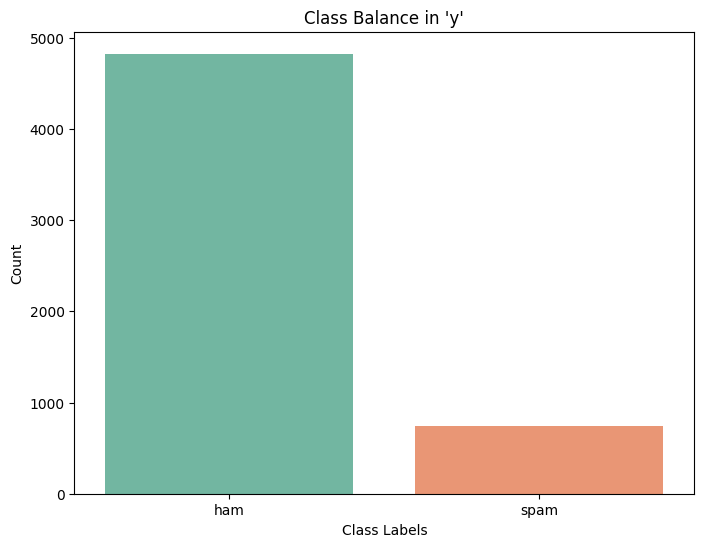

In [26]:
eda.plot_class_balance("y")

# Data Processing


In [27]:
X_train, X_test, y_train, y_test = loader.split_data(target_column="y")

Данные успешно разделены: 4457 тренировочных и 1115 тестовых образцов.


In [28]:
display(X_train.head())

,X
1978,No I'm in the same boat. Still here at my moms...
3989,(Bank of Granite issues Strong-Buy) EXPLOSIVE ...
3935,They r giving a second chance to rahul dengra.
4078,O i played smash bros &lt;#&gt; religiously.
4086,PRIVATE! Your 2003 Account Statement for 07973...


In [29]:
config = {
    "remove_html_tags": True,
    "remove_emails": True,
    "remove_urls": True,
    "lowercase": True,
    "expand_contractions": True,
    "remove_stopwords": True,
    "remove_punctuation": True,
    "lemmatize": True,
    "stem_words": False,  # Мы можем выбрать либо стемминг, либо лемматизацию
    "remove_digits": True,
    "remove_extra_spaces": True,
}

In [30]:
pipeline = TextPreprocessingPipeline(config)

In [31]:
X_train_processed = pipeline.preprocess_column(X_train, "X")

100%|██████████| 4457/4457 [00:12<00:00, 350.84it/s]


In [32]:
X_test_processed = pipeline.preprocess_column(X_test, "X")

100%|██████████| 1115/1115 [00:03<00:00, 293.50it/s]


In [33]:
display(X_train_processed[["X", "X_processed"]])

,X,X_processed
1978,No I'm in the same boat. Still here at my moms...,boat still mom check yo half naked
3989,(Bank of Granite issues Strong-Buy) EXPLOSIVE ...,bank granite issue strong buy explosive pick m...
3935,They r giving a second chance to rahul dengra.,give second chance rahul dengra
4078,O i played smash bros &lt;#&gt; religiously.,play smash bros lt gt religiously
4086,PRIVATE! Your 2003 Account Statement for 07973...,private account statement show un redeem point...
...,...,...
3772,I came hostel. I m going to sleep. Plz call me...,come hostel go sleep plz call class hrishi
5191,"Sorry, I'll call later",sorry call later
5226,Prabha..i'm soryda..realy..frm heart i'm sory,prabha soryda realy frm heart sory
5390,Nt joking seriously i told,not joke seriously tell


In [34]:
display(X_train_processed.head())

,X,X_processed
1978,No I'm in the same boat. Still here at my moms...,boat still mom check yo half naked
3989,(Bank of Granite issues Strong-Buy) EXPLOSIVE ...,bank granite issue strong buy explosive pick m...
3935,They r giving a second chance to rahul dengra.,give second chance rahul dengra
4078,O i played smash bros &lt;#&gt; religiously.,play smash bros lt gt religiously
4086,PRIVATE! Your 2003 Account Statement for 07973...,private account statement show un redeem point...


# Model Training


In [35]:
embedding_model = EmbeddingModel("word2vec-google-news-300")

Загрузка предобученной модели эмбеддингов 'word2vec-google-news-300'...
Модель 'word2vec-google-news-300' загружена успешно!


In [36]:
X_train_embeddings = embedding_model.apply_embeddings(X_train_processed, "X")
X_test_embeddings = embedding_model.apply_embeddings(X_test_processed, "X")

100%|██████████| 1115/1115 [00:00<00:00, 23755.25it/s]


In [37]:
X_train_processed_text = X_train_processed["X"]
X_test_processed_text = X_test_processed["X"]

In [38]:
# Параметры для логистической регрессии
lr_params = {
    "C": 0.1,  # Регуляризация (меньше значение - больше регуляризация)
    "solver": "liblinear",  # Метод оптимизации
    "penalty": "l2",  # Тип регуляризации (l1, l2)
    "max_iter": 200,  # Максимальное количество итераций
    "random_state": 42,  # Фиксированный random state для воспроизводимости
}

# Параметры для случайного леса
rf_params = {
    "n_estimators": 200,  # Количество деревьев в лесу
    "max_depth": 10,  # Максимальная глубина дерева
    "min_samples_split": 5,  # Минимальное количество образцов для разбиения узла
    "min_samples_leaf": 2,  # Минимальное количество образцов в листовом узле
    "max_features": "sqrt",  # Количество признаков для выбора при разделении узла
    "bootstrap": True,  # Использовать ли bootstrap при построении деревьев
    "random_state": 42,  # Фиксированный random state для воспроизводимости
}

In [39]:
model_trainer = MLModelTrainer(model_type="LogisticRegression")
# RandomForest

In [40]:
print("\nTraining with BoW:")
bow_model, bow_vectorizer = model_trainer.train_with_bow(
    X_train_processed_text, y_train
)

X_test_bow = bow_vectorizer.transform(X_test_processed_text)


Training with BoW:


In [41]:
print("\nTraining with TF-IDF:")
tfidf_model, tfidf_vectorizer = model_trainer.train_with_tfidf(
    X_train_processed_text, y_train
)

X_test_tfidf = tfidf_vectorizer.transform(X_test_processed_text)


Training with TF-IDF:


In [42]:
embeddings_model = model_trainer.train_with_embeddings(X_train_embeddings, y_train)

# Model Evaluation


In [43]:
evaluator = ModelEvaluator()

,Metric,Value
0,Accuracy,0.963229
1,Balanced Accuracy,0.888670
2,Precision,0.962435
3,Recall,0.963229
4,F1 Score,0.961919
5,ROC-AUC,0.971682


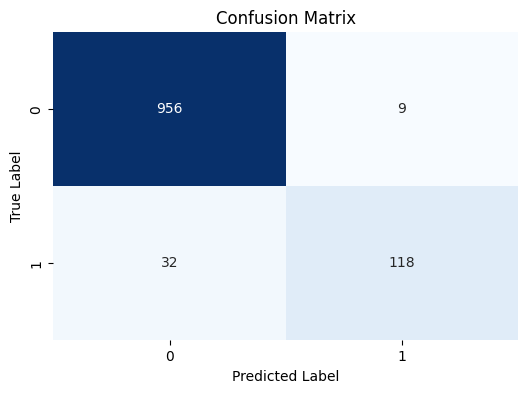

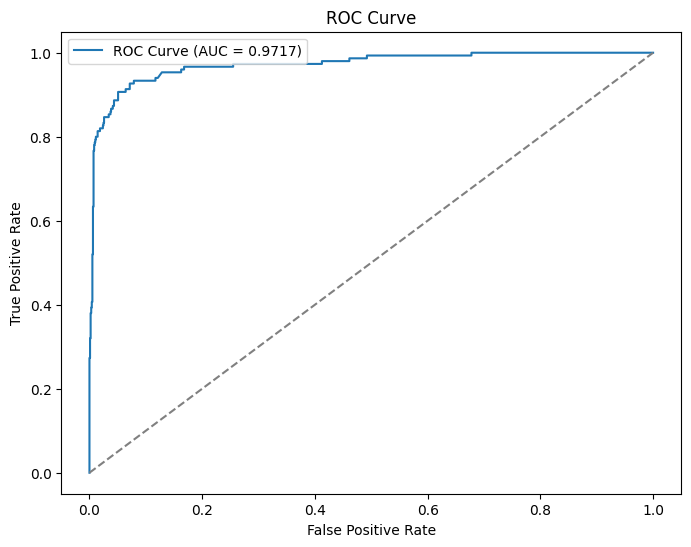


        Описание метрик:

        1. **Accuracy** — точность. Соотношение правильно предсказанных наблюдений к общему числу наблюдений. 
           Пример: 80% — это значит, что 80% наблюдений были предсказаны правильно.

        2. **Balanced Accuracy** — сбалансированная точность. Среднее значение между точностью по каждому классу, особенно полезна при несбалансированных классах.

        3. **Precision** — точность. Соотношение правильно предсказанных положительных наблюдений ко всем предсказанным положительным наблюдениям. 
           Пример: Если модель предсказала 100 положительных случаев, но только 80 из них были правильными, точность составит 80%.

        4. **Recall** — полнота. Соотношение правильно предсказанных положительных наблюдений ко всем реальным положительным наблюдениям. 
           Пример: Если есть 100 положительных случаев и модель нашла 80 из них, то полнота будет 80%.

        5. **F1 Score** — гармоническое среднее между точностью и полнотой. Это мера, кото

,Metric,Value
0,Accuracy,0.963229
1,Balanced Accuracy,0.888670
2,Precision,0.962435
3,Recall,0.963229
4,F1 Score,0.961919
5,ROC-AUC,0.971682


In [44]:
evaluator.display_results(embeddings_model, X_test_embeddings, y_test, show_help=True)

In [45]:
# 2. Сравнение моделей
models = {
    "BoW": bow_model,
    "TF-IDF": tfidf_model,
    "Embeddings": embeddings_model,
}

test_data = {
    "BoW": X_test_bow,
    "TF-IDF": X_test_tfidf,
    "Embeddings": X_test_embeddings,
}

,Accuracy,Balanced Accuracy,Precision,Recall,F1 Score,ROC-AUC
BoW,0.977578,0.919482,0.977917,0.977578,0.976780,0.981803
TF-IDF,0.967713,0.882815,0.968518,0.967713,0.965929,0.984000
Embeddings,0.963229,0.888670,0.962435,0.963229,0.961919,0.971682



        Описание метрик:

        1. **Accuracy** — точность. Соотношение правильно предсказанных наблюдений к общему числу наблюдений. 
           Пример: 80% — это значит, что 80% наблюдений были предсказаны правильно.

        2. **Balanced Accuracy** — сбалансированная точность. Среднее значение между точностью по каждому классу, особенно полезна при несбалансированных классах.

        3. **Precision** — точность. Соотношение правильно предсказанных положительных наблюдений ко всем предсказанным положительным наблюдениям. 
           Пример: Если модель предсказала 100 положительных случаев, но только 80 из них были правильными, точность составит 80%.

        4. **Recall** — полнота. Соотношение правильно предсказанных положительных наблюдений ко всем реальным положительным наблюдениям. 
           Пример: Если есть 100 положительных случаев и модель нашла 80 из них, то полнота будет 80%.

        5. **F1 Score** — гармоническое среднее между точностью и полнотой. Это мера, кото

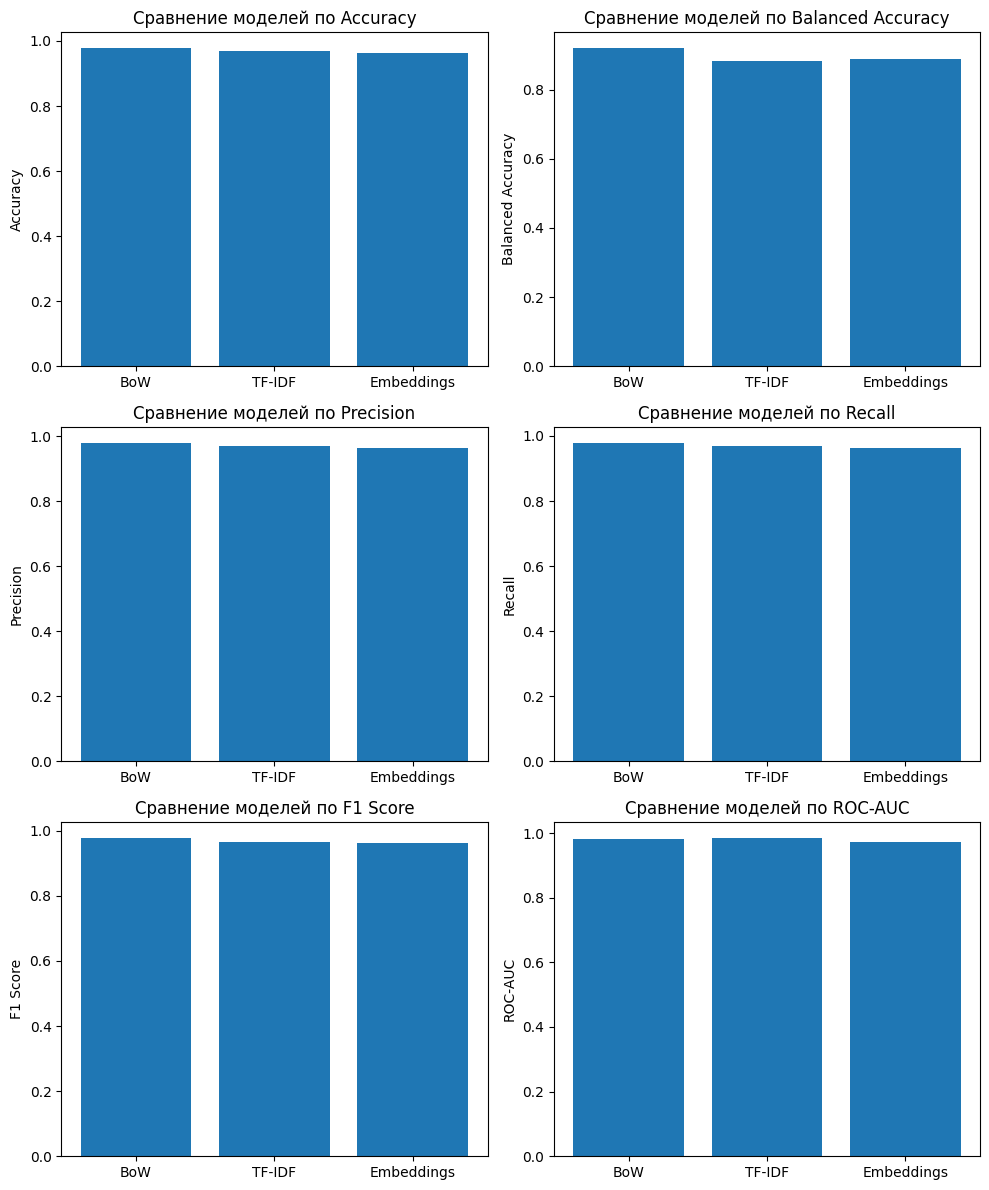

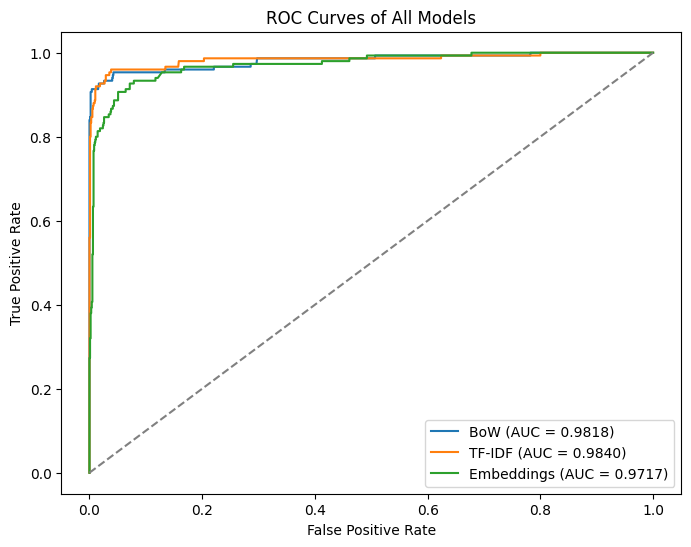

In [46]:
evaluator.compare_models(models, test_data, y_test, show_help=True, n_cols=2)

# Conclusion

Analysis and Interpretation of Results:

BoW Model:

Best performance overall with an accuracy of 0.977 and the highest F1 score of 0.977.

Strengths: High precision and recall, indicating that this model is highly reliable for spam detection with minimal false positives and negatives.

Weaknesses: BoW models can be computationally expensive due to the high dimensionality of sparse matrices.

TF-IDF Model:

Slightly lower accuracy (0.968) and F1 score (0.966) compared to BoW, but best ROC-AUC score of 0.984.

Strengths: Good at capturing the importance of specific words, leading to higher discrimination between classes.

Weaknesses: Slightly lower balanced accuracy (0.883) suggests it may not perform as well on imbalanced data.

Embeddings Model:

The lowest accuracy (0.963) and F1 score (0.962), but still competitive.

Strengths: Embeddings capture semantic meaning and relationships between words, which could be advantageous for more complex tasks.

Weaknesses: May underperform on small datasets where word representations aren't as meaningful or fully leveraged.

Conclusion:

The BoW model performs best for this spam classification task, with the highest accuracy and balanced performance across all metrics. The TF-IDF model excels in ROC-AUC, showing strong discrimination, while embeddings provide a semantic approach but slightly lower results in this case.